# Vienna OSMnx data

## Imports

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import os
import re
import pickle
import copy
import networkx as nx
from shapely.geometry import LineString

import sys
sys.path.append('../src/data')
from download_pois_networks import download_POIs
from download_pois_networks import download_street_network, networks_to_gdf, analyze_street_network

## Retrieve data

In [5]:
# Download POIs
tags={'shop':['supermarket'],'leisure':['park']}
boundary, pois = download_POIs(place_name="Vienna, Austria", tags=tags)

Total POIs: 2156
Found 1046 shop-supermarket
Found 1110 leisure-park


In [6]:
# Download networks
boundary, networks = download_street_network("Vienna, Austria", network_types=['drive', 'bike', 'walk'])
    
# Convert to GeoDataFrame for visualization
streets_gdf = networks_to_gdf(networks)

# Analyze networks
network_stats = analyze_street_network(networks)
print("\nNetwork Statistics:")
for network_type, stats in network_stats.items():
    print(f"\n{network_type.capitalize()} Network:")
    for stat, value in stats.items():
        print(f"  {stat}: {value:.2f}" if isinstance(value, float) else f"  {stat}: {value}")

Drive network: 16056 nodes, 35742 edges
Bike network: 50833 nodes, 125064 edges
Walk network: 126905 nodes, 367144 edges
Computed Network Statistics

Network Statistics:

Drive Network:
  node_count: 16056
  edge_count: 35742
  total_edge_length_km: 4507.67
  avg_edge_length_m: 126.12
  avg_node_degree: 4.45
  connected_components: 1
  avg_street_density: 7.93

Bike Network:
  node_count: 50833
  edge_count: 125064
  total_edge_length_km: 9709.76
  avg_edge_length_m: 77.64
  avg_node_degree: 4.92
  connected_components: 1
  avg_street_density: 12.88

Walk Network:
  node_count: 126905
  edge_count: 367144
  total_edge_length_km: 16795.70
  avg_edge_length_m: 45.75
  avg_node_degree: 5.79
  connected_components: 1
  avg_street_density: 21.86


## Hexagons

In [23]:
from h3 import h3
from shapely.geometry import Polygon
import geopandas as gpd

In [42]:
def create_hexagonal_grid(boundary, resolution=8):
    """Create hexagonal grid inside boundary.

    Args:
        boundary (GeoDataFrame): boundary polygon
        resolution (int, optional): resolution of tessellation. Defaults to 8.

    Returns:
        GeoDataFrame: geodf of hexagons
    """
    # Get boundary polygon coordinates
    boundary_shape = boundary.geometry.iloc[0]
    
    # Get hexagons that intersect with the boundary
    hex_ids = list(h3.polyfill(
        boundary_shape.__geo_interface__,
        resolution
    ))
    
    # Convert hexagons to polygons
    hex_polygons = []
    for hex_id in hex_ids:
        polygon_coords = h3.h3_to_geo_boundary(hex_id)
        polygon = Polygon(polygon_coords)
        hex_polygons.append({
            'geometry': polygon,
            'hex_id': hex_id
        })
    
    # Convert to GeoDataFrame
    geodf_hex = gpd.GeoDataFrame(hex_polygons)

    return geodf_hex

<Axes: >

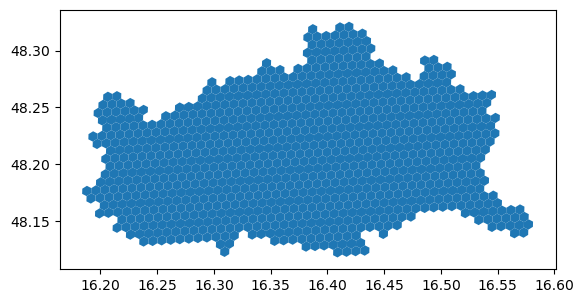

In [43]:
geodf_hex = create_hexagonal_grid(boundary)
geodf_hex.plot()